# Telco Customer Churn Prediction with AutoGluon

이 노트북은 AutoGluon을 사용하여 통신사 고객 이탈을 예측하는 모델을 만듭니다.

**순서**
1. 컬럼별로 데이터 분석 및 시각화
2. 전처리
3. 특성 엔지니어링
4. 모델링
5. 앙상블
6. 모델 비교 평가
7. submission.csv 파일 생성

| 분류 | 고객 인구통계 및 결제 (Demographics & Billing) | 분류 | 서비스 가입 정보 (Services & Contract) |
| :--- | :--- | :--- | :--- |
| **customerID** | 고객 식별 번호 (ID) | **tenure** | 고객의 가입 기간 (개월 수) |
| **gender** | 성별 (Female, Male) | **PhoneService** | 전화 서비스 사용 여부 |
| **SeniorCitizen** | 고령자 여부 (0:젊은층, 1:고령자) | **MultipleLines** | 다중 회선 사용 여부 |
| **Partner** | 배우자 유무 (Yes, No) | **InternetService** | 인터넷 서비스 제공업체 종류 |
| **Dependents** | 부양가족 유무 (Yes, No) | **OnlineSecurity** | 온라인 보안 서비스 유무 |
| **PaperlessBilling** | 전자청구서 사용 여부 (Yes, No) | **OnlineBackup** | 온라인 백업 서비스 유무 |
| **PaymentMethod** | 결제 방법 (카드, 이체, 수표 등) | **DeviceProtection** | 기기 보호 서비스 유무 |
| **MonthlyCharges** | 월간 요금 (Monthly) | **TechSupport** | 기술 지원 서비스 유무 |
| **TotalCharges** | 총 누적 요금 (수치형 변환 필요) | **StreamingTV** | 스트리밍 TV 이용 유무 |
| **Churn** | **고객 이탈 여부 (Target: Yes/No)** | **StreamingMovies** | 스트리밍 영화 이용 유무 |
| **Contract** | **계약 기간 (1개월/1년/2년)** | | |

In [2]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
# 1. 라이브러리 임포트 및 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 데이터 로드
data_path = 'data/Telco-Customer-Churn.csv'
df = pd.read_csv(data_path)


# 데이터 확인
display(df.head())
display(df.info())

c:\Users\COM\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

In [20]:
import pandas as pd
import os

# 1. 파일 존재 여부 먼저 확인
file_path = 'data/Telco-Customer-Churn.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("✅ 데이터 로드 성공!")
    
    # 2. 'df'가 판다스 데이터프레임인지 확인
    if isinstance(df, pd.DataFrame):
        print("✅ df 변수가 데이터프레임으로 정상 선언되었습니다.")
        display(df.head())  # 이제 에러 없이 작동할 것입니다.
    else:
        print("❌ 변수 df가 데이터프레임이 아닙니다.")
else:
    print(f"❌ 에러: {file_path} 경로에 파일이 없습니다. 경로를 확인해주세요!")

✅ 데이터 로드 성공!
✅ df 변수가 데이터프레임으로 정상 선언되었습니다.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
# 데이터 전처리 전, TotalCharges의 빈 문자열 처리 필요
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

C:\Users\COM\AppData\Local\Temp\ipykernel_42868\1319828881.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


# 2. 컬럼별 데이터 분석 및 시각화 (EDA)
데이터의 분포와 이탈률(Churn)과의 관계를 살펴봅니다.

In [22]:
# Churn을 수치형으로 변환 (시각화를 위해)
df['Churn_Numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [25]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


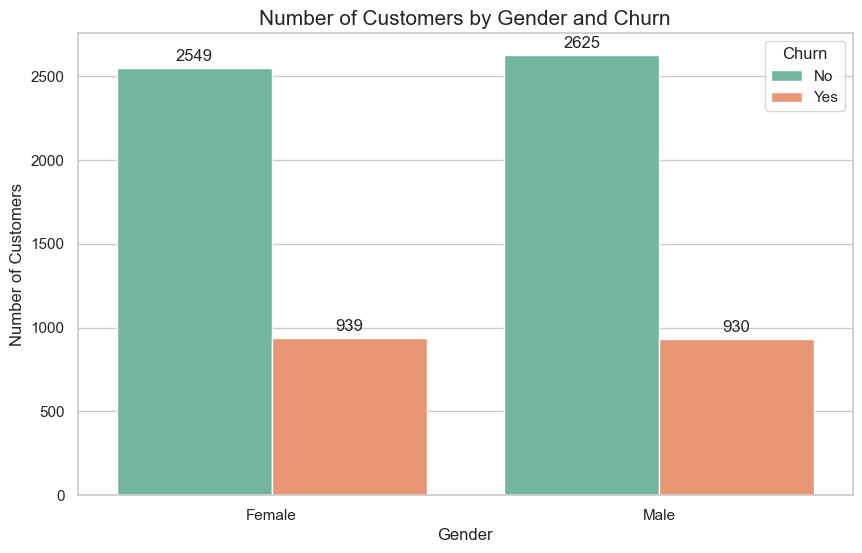

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 1. countplot으로 성별별 이탈 여부 인원수 시각화
# x축은 성별, hue는 이탈 여부(Yes/No)
ax = sns.countplot(x='gender', hue='Churn', data=df, palette='Set2')

# 2. 막대 위에 인원수(Count) 레이블 추가
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

# 3. 그래프 꾸미기
plt.title('Number of Customers by Gender and Churn', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', loc='upper right')
plt.show()

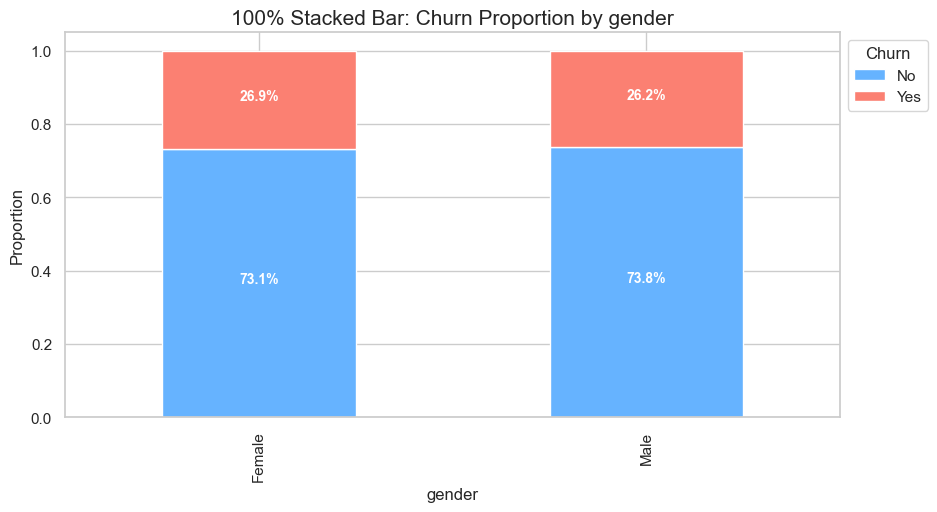

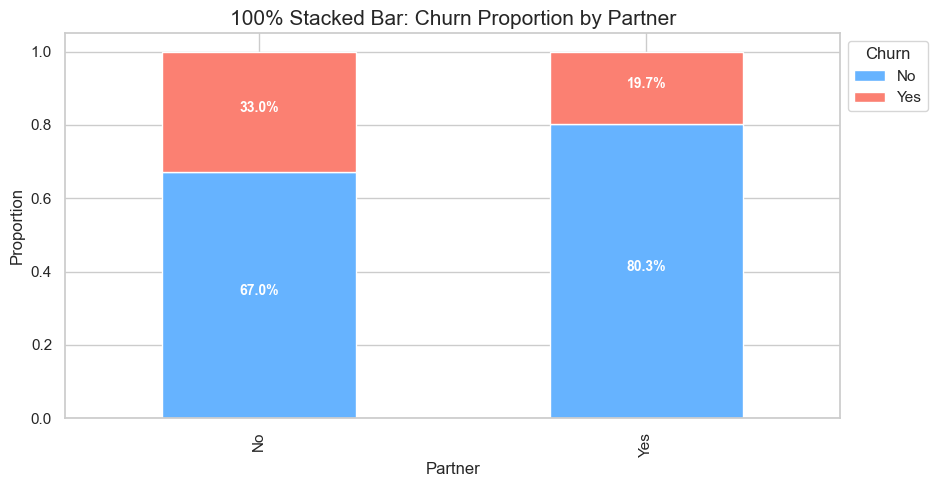

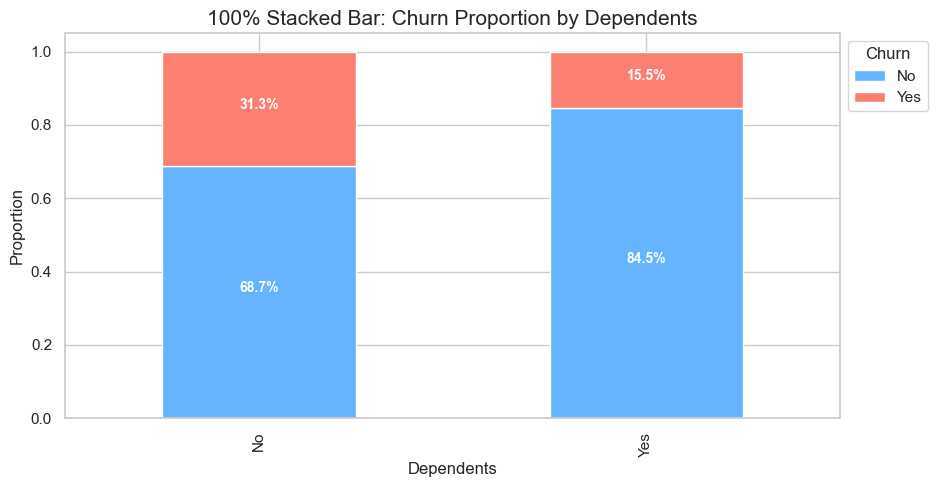

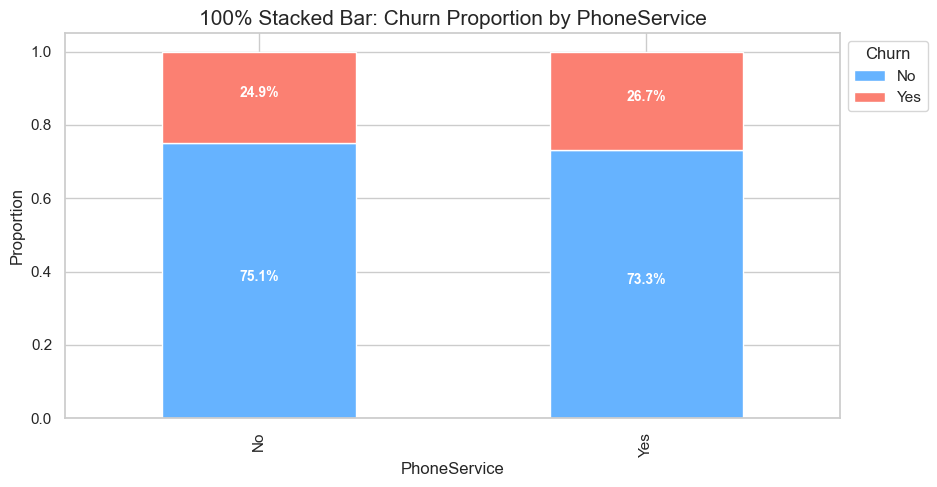

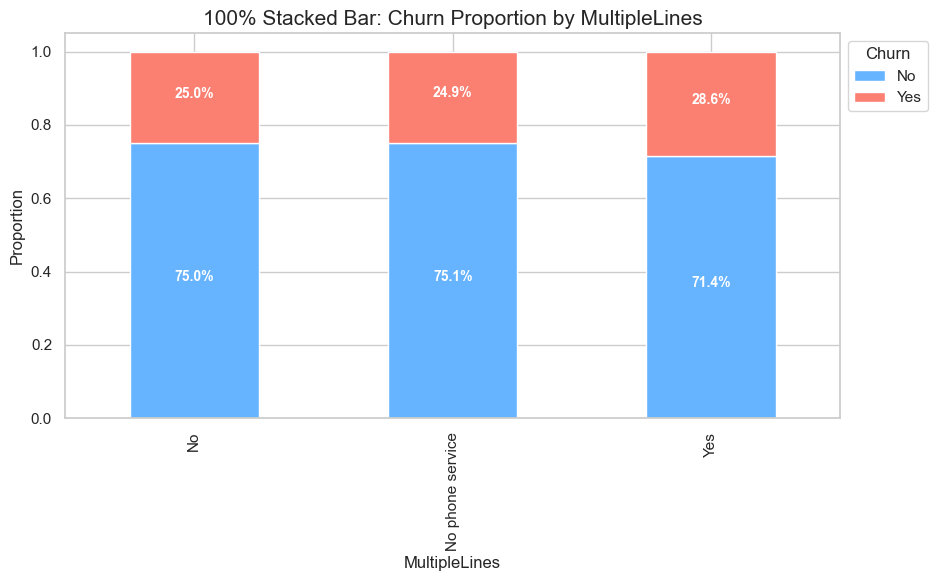

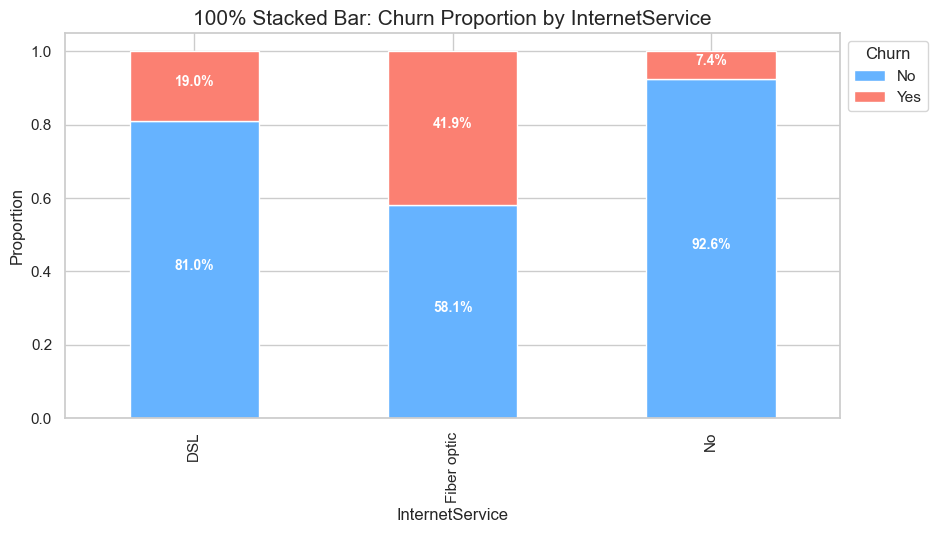

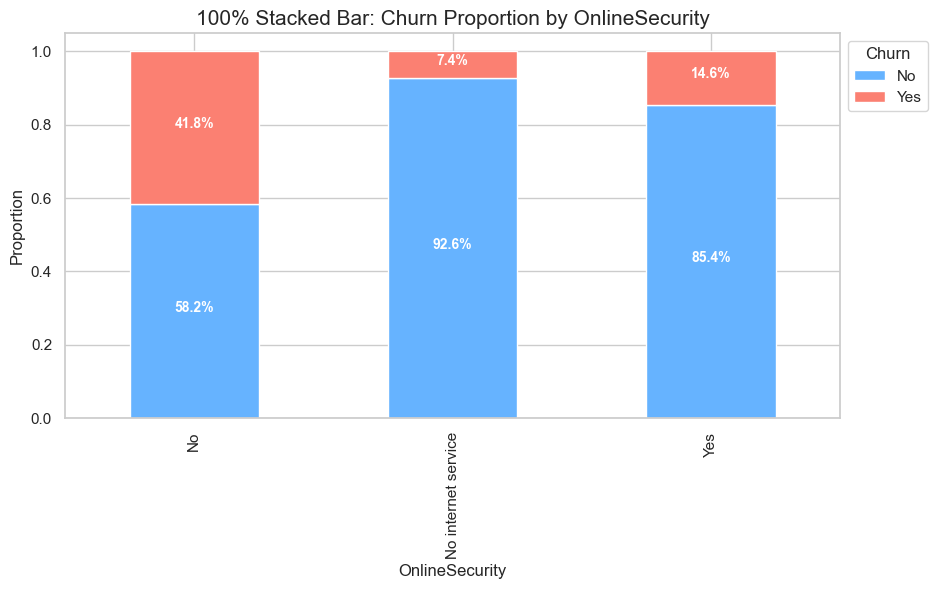

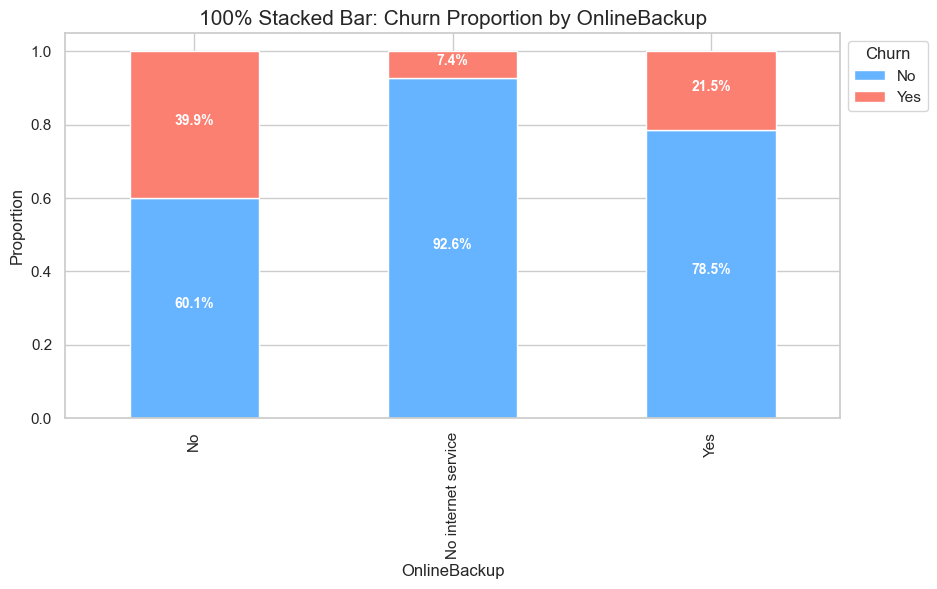

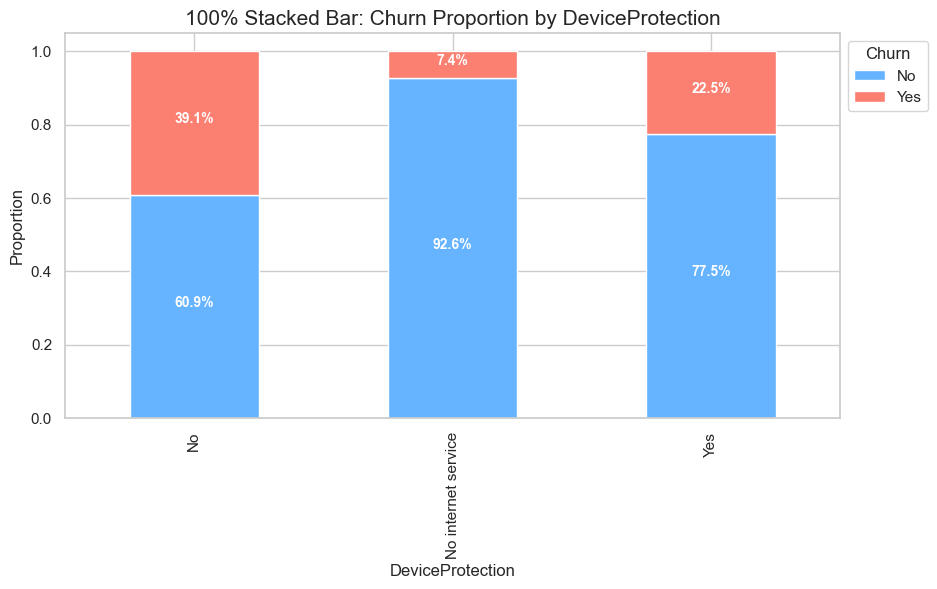

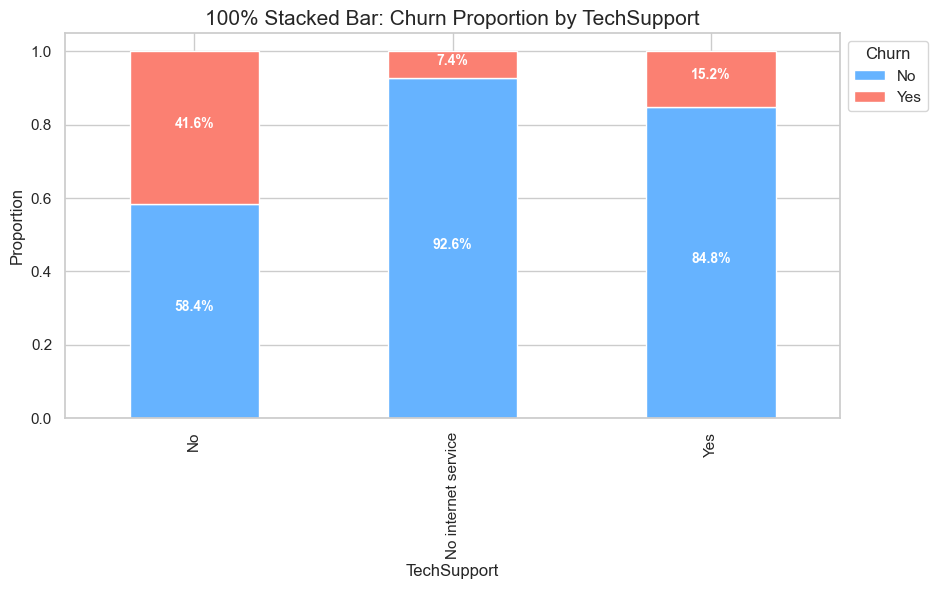

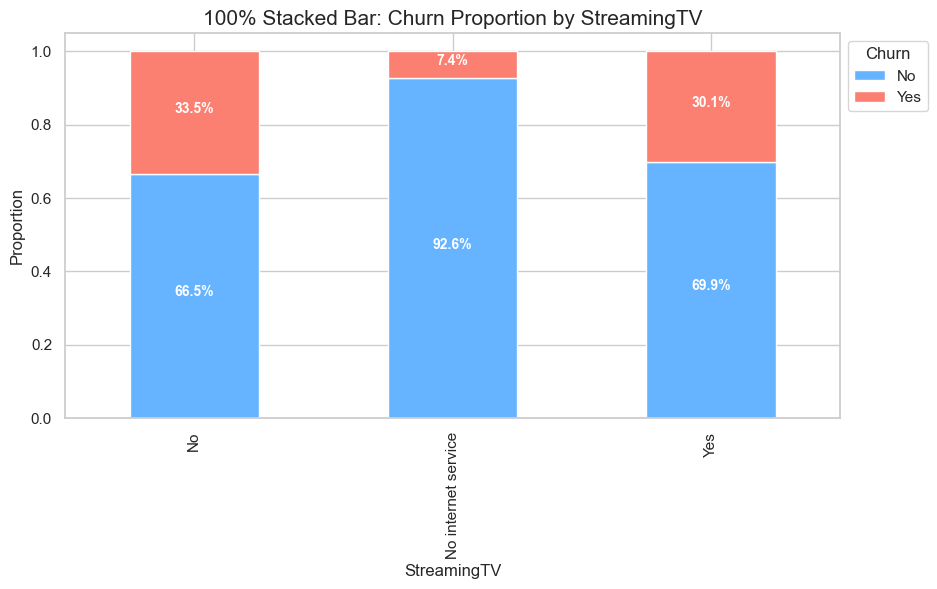

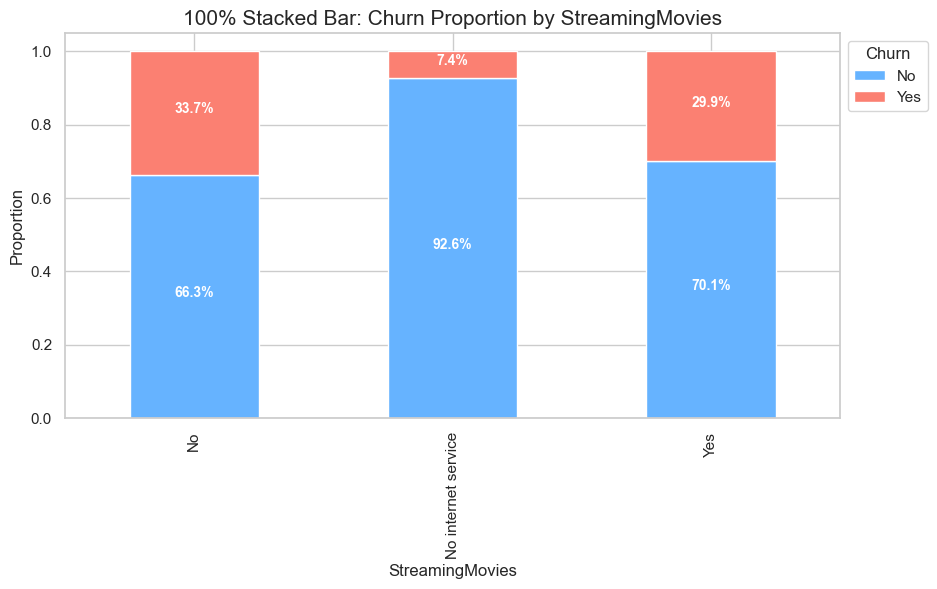

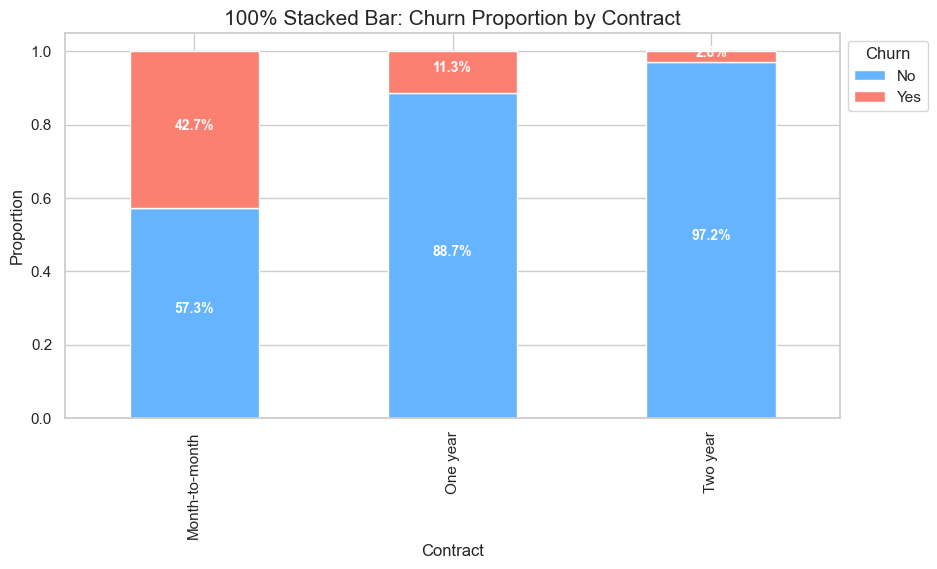

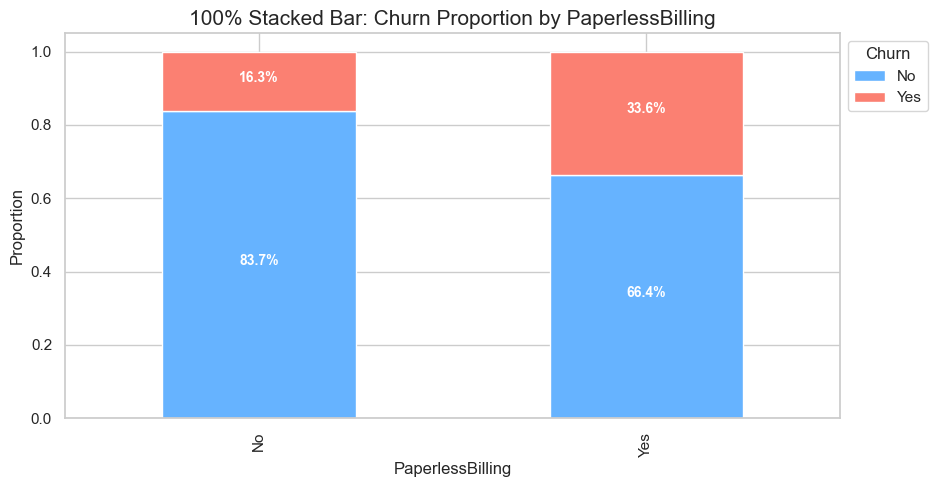

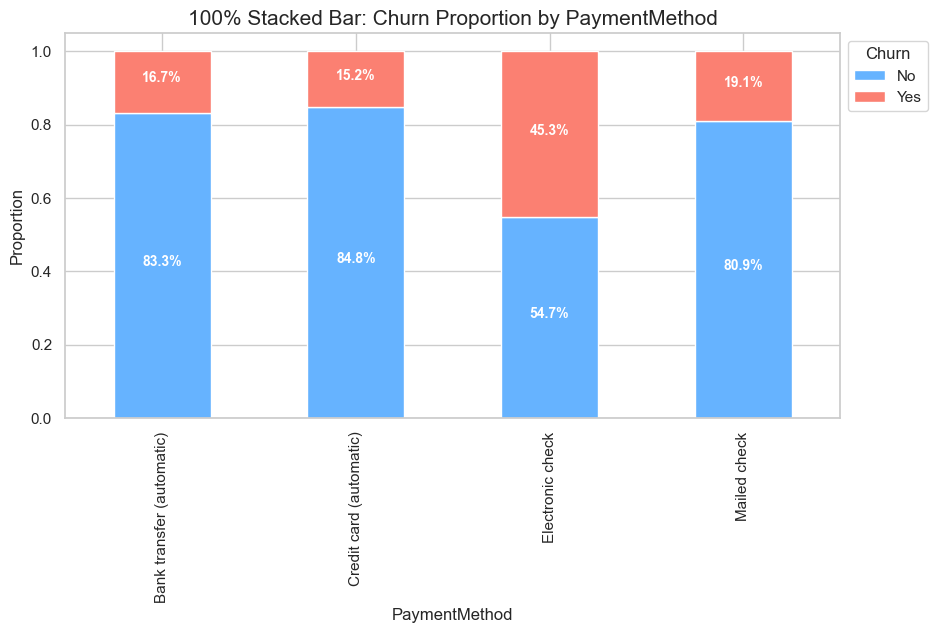

In [30]:
for col in cat_cols:
    # 1. 교차표 생성 (인원수)
    cross_tab = pd.crosstab(df[col], df['Churn'])
    
    # 2. 행 단위로 합계가 1이 되도록 정규화 (전체를 100으로 설정)
    cross_tab_prop = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)
    
    # 3. 그래프 그리기
    ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(10, 5), color=['#66b3ff','#fb8072'])
    
    # 4. 막대 안에 비율(%) 표시하기
    for n, x in enumerate([*cross_tab_prop.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                       cross_tab_prop.loc[x].cumsum()):
            plt.text(x=n,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{proportion*100:.1f}%', 
                     color="white",
                     fontsize=10,
                     fontweight="bold",
                     ha="center")

    plt.title(f'100% Stacked Bar: Churn Proportion by {col}', fontsize=15)
    plt.ylabel('Proportion')
    plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

Numeric Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


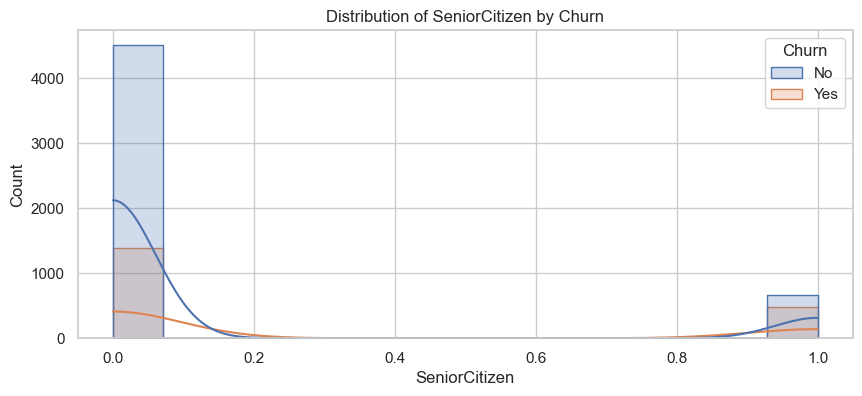

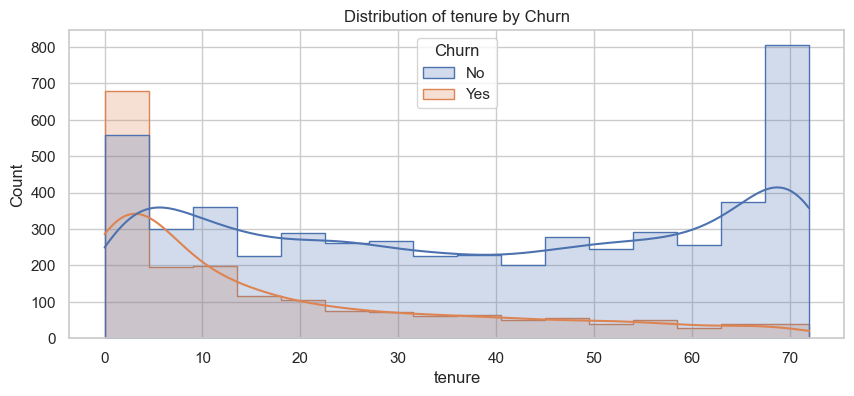

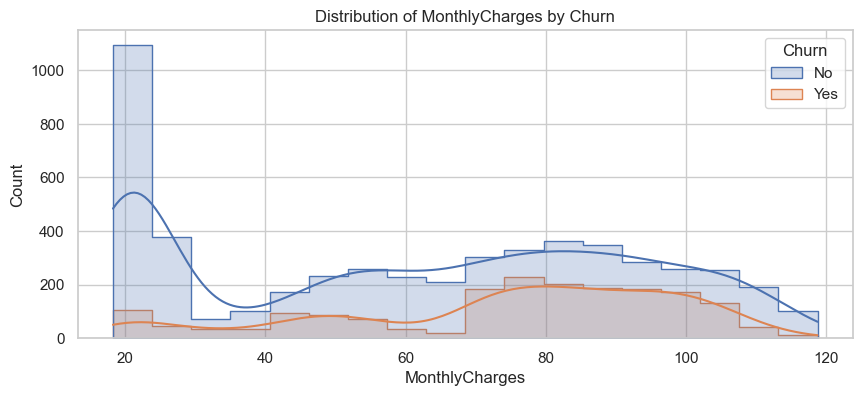

In [ ]:
num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'Churn_Numeric']

print("Numeric Columns:", num_cols)

# 수치형 데이터 시각화
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, element="step")
    plt.title(f'Distribution of {col} by Churn')
    plt.show()

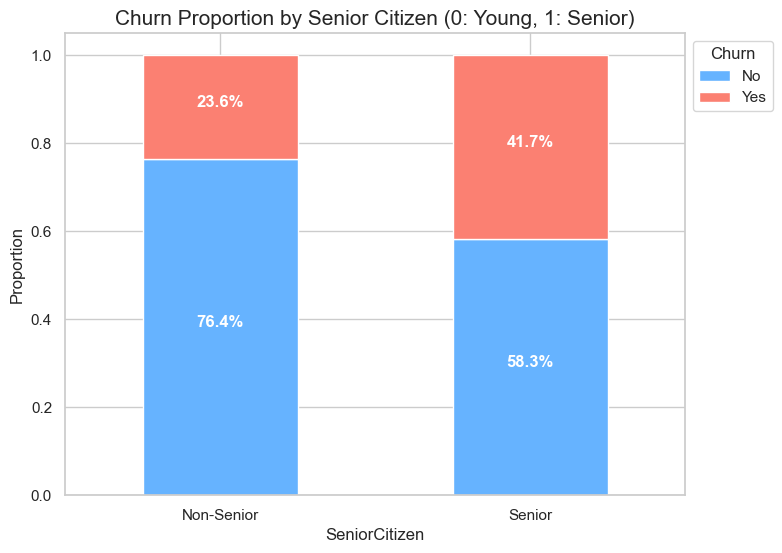

In [31]:
# 1. 교차표 생성 (0: 젊은 층, 1: 고령자)
cross_tab = pd.crosstab(df['SeniorCitizen'], df['Churn'])

# 2. 비율로 변환 (전체 합을 100%로 설정)
cross_tab_prop = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)

# 3. 그래프 그리기
ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#66b3ff','#fb8072'])

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*cross_tab_prop.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
        plt.text(x=n,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="white",
                 fontsize=12,
                 fontweight="bold",
                 ha="center")

plt.title('Churn Proportion by Senior Citizen (0: Young, 1: Senior)', fontsize=15)
plt.xticks([0, 1], ['Non-Senior', 'Senior'], rotation=0) # 라벨을 보기 쉽게 변경
plt.ylabel('Proportion')
plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

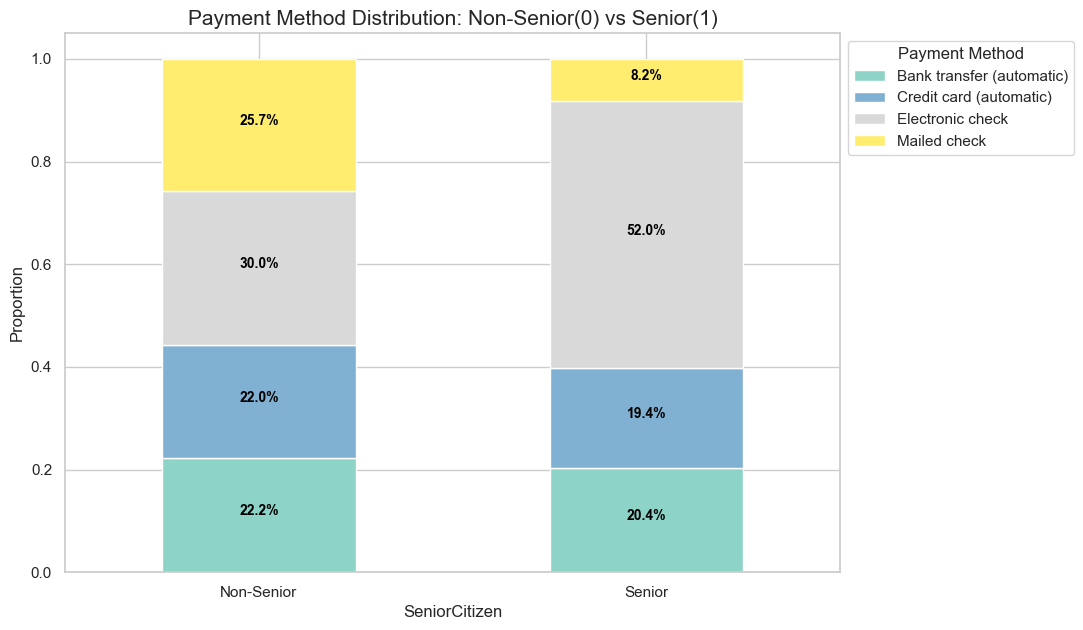

In [33]:
# 1. SeniorCitizen과 PaymentMethod의 교차표 생성
senior_payment = pd.crosstab(df['SeniorCitizen'], df['PaymentMethod'])

# 2. 비율로 변환 (각 그룹 내에서 어떤 결제수단을 많이 쓰는지)
senior_payment_prop = senior_payment.div(senior_payment.sum(1).astype(float), axis=0)

# 3. 시각화
ax = senior_payment_prop.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='Set3')

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*senior_payment_prop.index.values]):
    cumulative_height = 0
    for col in senior_payment_prop.columns:
        proportion = senior_payment_prop.loc[x, col]
        plt.text(x=n,
                 y=cumulative_height + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="black",
                 fontsize=10,
                 fontweight="bold",
                 ha="center")
        cumulative_height += proportion

plt.title('Payment Method Distribution: Non-Senior(0) vs Senior(1)', fontsize=15)
plt.xticks([0, 1], ['Non-Senior', 'Senior'], rotation=0)
plt.ylabel('Proportion')
plt.legend(title='Payment Method', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

C:\Users\COM\AppData\Local\Temp\ipykernel_42868\531965128.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen',
C:\Users\COM\AppData\Local\Temp\ipykernel_42868\531965128.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen',
C:\Users\COM\AppData\Local\Temp\ipykernel_42868\531965128.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # 라벨 회전
C:\Users\COM\AppData\Local\Temp\ipykernel_42868\531965128.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

<Figure size 1200x600 with 0 Axes>

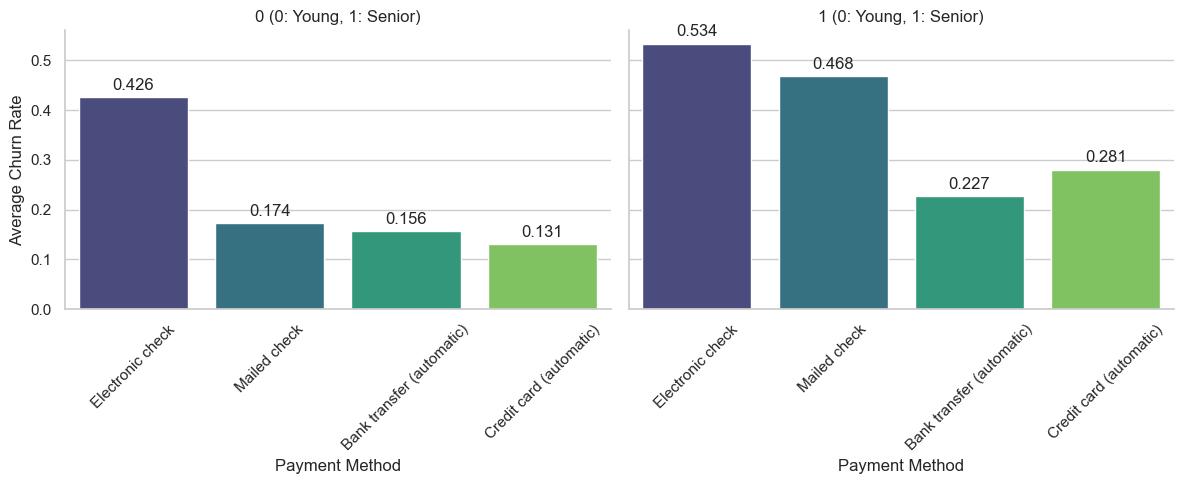

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 고령자 여부에 따른 결제 수단별 이탈률 시각화
plt.figure(figsize=(12, 6))

# catplot은 여러 개의 그래프를 나란히 그리기에 아주 좋습니다.
g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen', 
                data=df, kind='bar', palette='viridis', ci=None, height=5, aspect=1.2)

# 각 막대 위에 수치(이탈률) 표시
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # 라벨 회전

g.set_axis_labels("Payment Method", "Average Churn Rate")
g.set_titles("{col_name} (0: Young, 1: Senior)")
plt.tight_layout()
plt.show()

In [35]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


# 3. 데이터 전처리 (Preprocessing)
- 불필요한 컬럼 제거 (`customerID`, 시각화용 `Churn_Numeric`)
- 결측치 처리 (이미 위에서 수행함)

In [ ]:
# 불필요한 컬럼 제거
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

if 'Churn_Numeric' in df.columns:
    df = df.drop('Churn_Numeric', axis=1)

# 결측치 재확인
print(df.isnull().sum())

# 4. 특성 엔지니어링 (Feature Engineering)
- `TenureGroup`: 가입 기간을 그룹화
- `ServicesCount`: 가입한 부가 서비스 수
- `ContractType`: 계약 형태 단순화 (선택 사항)

In [ ]:
# Tenure Grouping
def tenure_group(tenure):
    if tenure <= 12:
        return '0-1 Year'
    elif tenure <= 24:
        return '1-2 Years'
    elif tenure <= 48:
        return '2-4 Years'
    elif tenure <= 60:
        return '4-5 Years'
    else:
        return '5+ Years'

df['TenureGroup'] = df['tenure'].apply(tenure_group)

# Service Count
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['ServiceCount'] = df[services].apply(lambda x: (x == 'Yes').sum(), axis=1)

display(df.head())

# 데이터 분할
모델 학습 및 평가, 그리고 최종 submission 생성을 위해 데이터를 분할합니다.
제출 파일 생성을 위한 별도의 test 파일이 없으므로, 전체 데이터의 20%를 test set(hold-out)으로 분리하여 사용합니다.

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Churn'])
print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")

# 5. 모델링 (Modeling with AutoGluon)
AutoGluon의 TabularPredictor를 사용하여 학습합니다.

In [ ]:
label = 'Churn'
save_path = 'ag_models_churn'

predictor = TabularPredictor(label=label, path=save_path).fit(
    train_data,
    presets='best_quality',  # 고품질 모델 학습 (시간이 더 걸림). 빠른 학습을 원하면 'medium_quality' 등 사용
    time_limit=60*5  # 예시: 최대 5분 학습 (필요에 따라 조절)
)

# 6. 앙상블 (Ensemble) 및 모델 비교 평가
AutoGluon은 `best_quality` 프리셋에서 자동으로 앙상블 모델(WeightedEnsemble)을 생성합니다.

In [ ]:
# 리더보드 확인
leaderboard = predictor.leaderboard(test_data)
display(leaderboard)

# 성능 평가
perf = predictor.evaluate(test_data)
print("Performance on Test Data:")
print(perf)

# 7. submission.csv 파일 생성
테스트 데이터(Hold-out set)에 대한 예측 결과를 저장합니다.

In [ ]:
# 예측 (확률 포함)
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)

# 결과 데이터프레임 생성
submission = pd.DataFrame({
    'Actual': test_data['Churn'],
    'Predicted': y_pred,
    'Probability_Yes': y_pred_proba.iloc[:, 1]  # 'Yes' 클래스 확률
})

# 파일 저장
submission.to_csv('submission_autogluon.csv', index=False)
print("submission_autogluon.csv file generated.")
display(submission.head())